# TAL aplicado al análisis del discurso de los medios de prensa 📰🤓🔥


### Cronograma

- Hito Unidad 2 (27 de octubre): Implementación y experimentos de varios modelos de clasificación

- Hito Proyecto (15 de diciembre): Evaluación y comparación de los modelos de los distintos equipos + integración de los mejores modelos en la arquitectura Sophia2.


## índex
1. [Importación del dataset](a)
2. [Balancear dataset](b)
3. [Inicialización del modelo spaCy y tokenización](c)
4. [Definición de la arquitectura CNN](d)
5. [Funciones para optimizar el modelo](e)
6. [Funciones para evaluar el modelo](f)
7. [Optimización del modelo](g)
8. [Evaluación del modelo](h)   
    8.1 [Matriz de confusión](k)


In [2]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install tqdm
#!pip install -U spacy
#!pip install torchtext
#!conda install pytorch-cpu torchvision-cpu -c pytorch

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import re
import pandas as pd
import numpy as np
import random

# Plotting
import matplotlib.pyplot as plt
from tqdm import tqdm


# NLP
import spacy
import torch
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data

In [4]:
print(torch.cuda.is_available())

False


### 1. Importación del dataset

In [5]:
df = pd.read_csv("topics.csv",sep=',',error_bad_lines=False)
df.drop(['Unnamed: 0'], axis = 1, inplace=True) # Para suprimir la columna ID
df.drop(columns=['text','media_outlet', 'url','topic'], inplace=True)

df = df.astype({"label": str})
df.replace("0.0","mundo", inplace=True)
df.replace("1.0","economia", inplace=True)
df.replace("2.0","politica", inplace=True)
df.replace("3.0","ciencia", inplace=True)
df.replace("6.0","deporte", inplace=True)
df.replace("8.0","crimen", inplace=True)
df.replace("9.0","salud", inplace=True)

df

,content,label
0,Edificio se inunda tras rotura de piscina en C...,politica
1,"Trump visita Kenosha y califica de ""terrorismo...",ciencia
2,El secreto detalle en la vestimenta de Pablo E...,ciencia
3,Extraño tiburón sin piel es avistado nadando e...,ciencia
4,"""Melania y yo"": La exmejor mejor amiga revela ...",ciencia
...,...,...
69308,"Paris destaca caída ""moderada"" de casos, pero ...",salud
69309,Diputado Ilabaca (PS) critica al Gobierno por ...,politica
69310,Provoste se distancia de anuncio del President...,politica
69311,"Vacunas CanSino, que requieren una sola dosis,...",salud


In [6]:
dfc = df[df['label']!="5.0"]
dfc = dfc[dfc['label']!="7.0"]
dfc['label'].value_counts()

salud       15221
politica    14140
mundo       11417
crimen      10700
deporte      9609
ciencia      5689
economia     2134
Name: label, dtype: int64

### 2. Balancear dataset
Realizaremos random undersampling

In [7]:
#!pip install imblearn

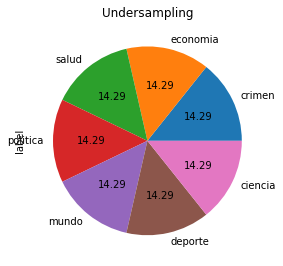

In [8]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=0)
x_res,y_res = undersample.fit_resample(dfc,dfc['label'])
fig, ax = plt.subplots(figsize=(4,4),tight_layout=True)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Undersampling")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
valid, test, train = np.split(x_res, [int(.15*len(x_res)), int(.3*len(x_res))])
print("Largo dataset entrenamiento: ", len(train))
print("Largo dataset validación: ", len(valid))
print("Largo dataset test", len(test))

Largo dataset entrenamiento:  10457
Largo dataset validación:  2240
Largo dataset test 2241


In [10]:
train.to_csv("CNN_train.csv", encoding="UTF-8",index=False)
valid.to_csv("CNN_valid.csv", encoding="UTF-8",index=False)
test.to_csv("CNN_test.csv", encoding="UTF-8",index=False)

### 3. Inicialización del modelo spaCy y tokenización

In [11]:
#!python -m spacy download es_core_news_sm

In [12]:
spacy_es = spacy.load('es_core_news_sm')
def tokenize_es(sentence):
    return [tok.text for tok in spacy_es.tokenizer(sentence)]



TEXT = data.Field(tokenize=tokenize_es, batch_first = True)
LABEL = data.LabelField()
fields = [('content', TEXT),('label', LABEL)]

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'CNN_train.csv',
                                        validation= 'CNN_valid.csv',
                                        test = 'CNN_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [13]:
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=lambda x:len(x.label),
    sort_within_batch=False)

cpu


### 4. Definición de la arquitectura CNN

In [14]:
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [15]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data, vectors=vec, max_size = MAX_VOCAB_SIZE, unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [16]:
print(LABEL.vocab.stoi)

defaultdict(None, {'economia': 0, 'mundo': 1, 'politica': 2, 'salud': 3, 'deporte': 4})


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
    
        super().__init__()
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        #text = text.permute(1, 0)    
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)     
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]    
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
        
        return self.fc(cat)

In [18]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

OUTPUT_DIM

5

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,272,405 trainable parameters


In [20]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

### 5. Funciones para optimizar el modelo

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss() #MULTICLASS ---> en lugar de .BCEWithLogitsLoss() (Binary Cross Entropy)

model = model.to(device)
criterion = criterion.to(device)

In [22]:
def train(model, iterator, optimizer, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in tqdm(iterator, desc='train'):
        
        optimizer.zero_grad()
        #print("Tamaño texto de entrada:"+str(batch.body.shape))
        
        predictions = model(batch.content)
        #print("Tamaño predecciones de salida:"+str(predictions.shape)) 
        #print("Tamaño target:"+str(batch.category.shape)) 
        
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label, divisor)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 6. Funciones para evaluar el modelo

In [24]:
def categorical_accuracy(preds, y, divisor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / divisor([y.shape[0]])

In [27]:
def evaluate(model, iterator, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in tqdm(iterator, desc='eval'):

            predictions = model(batch.content)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label, divisor)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 7. Optimización del modelo

In [28]:
print("inicio optimización")

N_EPOCHS = 1 #5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    divisor = torch.FloatTensor if str(device) == 'cpu' else torch.cuda.FloatTensor
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, divisor)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, divisor)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        name = './tematic-model-CNN'+'_ep'+str(epoch+1)+'.pt'
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': best_valid_loss}, name)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

inicio optimización


eval:   0%|                                                                  | 0/70 [00:00<?, ?it/s]


KeyError: 'crimen'

### 8. Evaluación del modelo

In [ ]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
name = './tematic-model-CNN'+'_ep'+str(2)+'.pt'
best_model.load_state_dict(torch.load(name, map_location=torch.device('cpu'))['model_state_dict'])

In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, divisor)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
prediction_test = []
labels_test=[]
for batch in test_iterator:
    labels_test.append(batch.category.cpu().detach().numpy())
    predictions = best_model(batch.body.cpu()).squeeze(1)
    #print(torch.sigmoid(predictions))
    rounded_preds = torch.round(torch.sigmoid(predictions))
    prediction_test.append(rounded_preds.detach().numpy())
    #print(prediction_test)
    

y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

#### 8.1 Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=test_targets, y_pred=prediction_test)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])
print(classification_report(test_targets, prediction_test, digits=3))